In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import numpy as np
import statsmodels.formula.api as sm
import statsmodels.stats.multitest as smm
import scipy.stats as scs
import seaborn as sns
import math
import matplotlib.colors as colors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load the data and filter for the genesets of interest
data_hpa = pd.read_csv('<Path to the tsv containing effect sizes for the genesets of interests>', sep='\t')
data_hpa_clean = data_hpa[(data_hpa.cat == 'g') &
                        (data_hpa.ancestry == 'All') &
                        (data_hpa.diagnosis == 'wo_ASD') &
                          (data_hpa.model_type == '1_3') 
                           ]
print(data_hpa_clean.shape)
data_all =  data_hpa_clean

(430, 22)


In [23]:
print('N lists', data_all.gene_list_name.nunique())
print('size lists', data_all.gene_list_n.mean())
all_list = ','.join(data_all.unique_genes.tolist()) 
print('number unique genes', len(set(all_list.split(','))))

print('del size lists', data_all[data_all.TYPE == 'DEL'].n_unique_genes.mean())
print('dup size lists', data_all[data_all.TYPE == 'DUP'].n_unique_genes.mean())

all_list = ','.join(data_all[data_all.TYPE == 'DEL'].unique_genes.tolist()) 
print('number unique DEL', len(set(all_list.split(','))))
all_list = ','.join(data_all[data_all.TYPE == 'DUP'].unique_genes.tolist()) 
print('number unique DUP', len(set(all_list.split(','))))

N lists 6130
size lists 89.08874550454834
number unique genes 11460
del size lists 32.963051251489865
dup size lists 43.60642833715973
number unique DEL 5369
number unique DUP 10374


In [24]:
# Prepare the data for the tagDS computation on our genesets of interest
ratio = 0.426609501927956 # Ratio of differences between average effect of DEL and DUP on cognitive ability
colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
all_colors = np.vstack((colors_dup, colors_del))
del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)

def compute_tagDS(es_data, data_CNV, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row.Estimate_DEL + b*row.Estimate_DUP + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row.Estimate_DEL - row.Estimate_DUP
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    es_data['tagDS'] = tagDS_vals 
    random_distri_tagDS = pd.read_csv('<Path to list of normalized tagDS for each geneset sizes>', sep='\t')
    tmp_data = pd.merge(es_data, data_CNV[data_CNV.TYPE=='DEL'].loc[:,['gene_list_name', 'gene_list_n']], on='gene_list_name', how='inner')

    tmp = pd.merge(tmp_data, random_distri_tagDS[['size', 'mu_s', 'sd_s']], left_on='gene_list_n', right_on='size', how='inner')
    tmp['zTagDS'] = (tmp['tagDS'] - tmp['mu_s'])/tmp['sd_s']
    return tmp

In [25]:
# Compute the adjusted p-values (FDR correction) for each gene list
new_data = pd.DataFrame()
for cnv_type in data_all.TYPE.unique():
    for combo in set(zip(data_all['model_type'], data_all['win'],  data_all['diagnosis'])):
        tmp = data_all[(data_all.TYPE==cnv_type) & (data_all.model_type==combo[0]) & (data_all.win==combo[1]) & (data_all.diagnosis==combo[2])].copy()
        tmp['pvalue_adj'] = smm.fdrcorrection(tmp['pvalue'])[1]
        new_data = pd.concat([new_data, tmp])

Total number of genesets = 3324
Percentage of both significant = 8.682170542635658 %
Total of significant regions = 645
4346
count     645.000000
mean        7.354097
std       157.060522
min      -257.363795
25%        -2.771285
50%        -0.738850
75%         0.827527
max      3288.030786
Name: del_over_dup, dtype: float64

Spearman corelation = -0.54 (p=3.42e-49)
Linear regression = -0.28, intercept = -0.09


ValueError: 0      1.598477
1      1.455425
2      2.202330
3      1.221137
4     -1.712363
         ...   
640    2.263788
641    1.950230
642    1.369567
643    2.064582
644    1.930027
Name: zTagDS, Length: 645, dtype: float64 is not a valid value for color

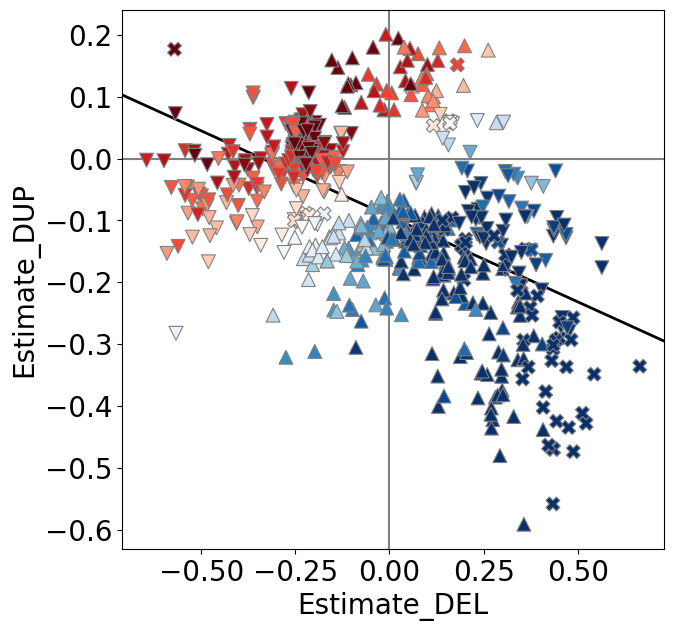

In [26]:
def plot_concordance(new_data, use_or=True, min_pval_del=1, min_pval_DUP=1):
    plt.rc('font', size=20)
    fig, ax = plt.subplots(figsize=(7,7))
    

    new_data_control = new_data[new_data.diagnosis=='wo_ASD']
    dels = new_data_control[(new_data_control.TYPE == 'DEL')][['gene_list_name','pvalue_adj', 'Estimate', 'total_carriers', 'unique_genes']]
    dels.columns =['gene_list_name', 'pvalue_DEL', 'Estimate_DEL', 'c_del', 'g_DEL']
    dups = new_data_control[new_data_control.TYPE == 'DUP'][['gene_list_name','pvalue_adj', 'Estimate', 'total_carriers', 'unique_genes']]
    dups.columns =['gene_list_name', 'pvalue_DUP', 'Estimate_DUP', 'c_dup', 'g_DUP']
    efs = pd.merge(dels, dups, on='gene_list_name', how='inner')

    if use_or:
        efs_filter= efs[(efs.pvalue_DEL <= min_pval_del) | (efs.pvalue_DUP <= min_pval_DUP)].copy()
    else:
        efs_filter= efs[(efs.pvalue_DEL <= min_pval_del) & (efs.pvalue_DUP <= min_pval_DUP)].copy()
    
    
    efs_filter['pval'] = np.where(efs_filter.pvalue_DEL < min_pval_del, np.where(efs_filter.pvalue_DUP < min_pval_DUP, 'mediumpurple', 'red'), 'steelblue')
    efs_filter['pval_lab'] = np.where(efs_filter.pvalue_DEL < min_pval_del, np.where(efs_filter.pvalue_DUP < min_pval_DUP, 'both significant', 'Del significant'), 'Dup significant')
    print('Total number of genesets = {}'.format(efs.shape[0]))
    print('Percentage of both significant =', efs_filter[efs_filter.pval == 'mediumpurple'].shape[0]/efs_filter.shape[0]*100, '%')
    print('Total of significant regions =', efs_filter.shape[0])
    
    del_list = ';'.join(efs_filter.g_DEL.tolist()) 
    print(len(set(del_list.split(','))))
    
    formula = 'Estimate_DUP ~ Estimate_DEL'
    reg = sm.gls(formula, data=efs_filter).fit()
    b, a = reg.params
    

    efs_filter['del_over_dup'] = efs_filter.Estimate_DEL / efs_filter.Estimate_DUP
    print(efs_filter.del_over_dup.describe())

    spear = scs.spearmanr(efs_filter.Estimate_DEL, efs_filter.Estimate_DUP)
    print('\nSpearman corelation = {:.2f} (p={:.2e})'.format(spear[0], spear[1]))
    print('Linear regression = {:.2f}, intercept = {:.2f}'.format(a, b))
    # efs_filter[['group', 'organ', 'tissue']] = efs_filter.gene_list_name.str.split('/', expand=True)
    efs_filter['shape'] = np.where(efs_filter.pvalue_DEL < 0.05, np.where(efs_filter.pvalue_DUP < 0.05, 'Both significant', "DEL significant") ,'DUP significant')

    
    # Plot overlay info
    plt.axhline(y=0, color = 'grey')
    plt.axvline(x=0, color = 'grey')
    plt.axline(xy1=(0, b), slope=a, alpha=1, color='black', lw=2)

    efs_filter = compute_tagDS(efs_filter, new_data_control, ratio)
    efs = compute_tagDS(efs, new_data_control, ratio)

    divnormtag = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)

    markers = {'Both significant':'X', "DEL significant":'v' ,'DUP significant':'^'}
    efs_filter['most'] = np.where(efs_filter.zTagDS > 0, np.where(efs_filter.zTagDS >= efs_filter.zTagDS.quantile(0.95), 2, .5), np.where(efs_filter.zTagDS <= efs_filter.zTagDS.quantile(0.05), 2, .5))
    
    sns.scatterplot(data=efs_filter, x='Estimate_DEL', y='Estimate_DUP', c=efs_filter.zTagDS, s=100, style='shape', markers=markers, zorder=3, norm=divnormtag, cmap=del_dup_spe,  edgecolor='gray')
    sns.scatterplot(data=efs_filter[efs_filter.most == 2], x='Estimate_DEL', y='Estimate_DUP', c=efs_filter[efs_filter.most == 2].zTagDS, s=100, style=efs_filter[efs_filter.most == 2]['shape'], markers=markers, zorder=3, norm=divnormtag, cmap=del_dup_spe,  edgecolor='gray', linewidth=2)

    print(efs_filter.Estimate_DEL.quantile(0.05))
    print(efs_filter.Estimate_DUP.quantile(0.05))
    
    print('min zTagDS = {:.3f}'.format(efs_filter.zTagDS.min()))
    print('max zTagDS = {:.3f}'.format(efs_filter.zTagDS.max()))
    print('Percentage >2sd = {:.3f}'.format(efs_filter[efs_filter.zTagDS.abs() >=2].shape[0]/efs_filter.shape[0]))
    print(efs_filter['shape'].value_counts())
    print(efs_filter.zTagDS.describe())
    
    print('average absolute tagDS = {:.3f}'.format(np.mean([abs(x) for x in efs_filter.zTagDS])))
    
    angle = abs((ratio-a)/(1+ratio*a))
    # angle = abs((-1-1)/(1+1*-0.99))
    print('Angle naive model gene-sets = {:.2f}°\n'.format(math.degrees(math.atan(angle))))
    
    # Plot background
    plt.axline(xy1=(0, 0), slope=ratio, alpha=0.5, color='black', lw=2, ls='--')

    plt.xlabel('Deletion effect sizes')
    plt.ylabel('Duplication effect sizes')
    plt.title('Spearman={:.2f} (p={:.1e})'.format(spear[0], spear[1]))
    ax.get_legend().remove()
    
    
    plt.show()
    print(efs)
    sns.scatterplot(data=efs, y='Estimate_DEL', x='gene_list_n', s=20, zorder=3, hue=np.where(efs.pvalue_DEL>0.05, 'non sig', 'sig'))
    plt.show()
    sns.scatterplot(data=efs, y='Estimate_DUP', x='gene_list_n', s=20, zorder=3, hue=np.where(efs.pvalue_DUP>0.05, 'non sig', 'sig'))
    plt.show()

    sns.scatterplot(data=efs_filter, y='c_del', x='gene_list_n', s=20, zorder=3, hue=np.where(efs_filter.pvalue_DEL>0.05, 'non sig', 'sig'))


    plt.show()
    sns.scatterplot(data=efs_filter, y='c_dup', x='gene_list_n', s=20, zorder=3, hue=np.where(efs_filter.pvalue_DEL>0.05, 'non sig', 'sig'))


    plt.show()
    
plot_concordance(new_data, use_or=True, min_pval_del=0.05, min_pval_DUP=0.05)

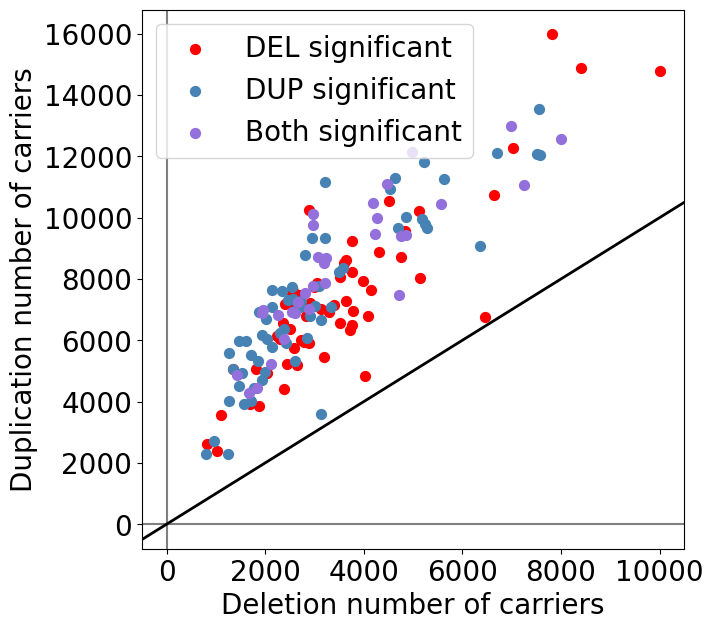

In [6]:
def plot_concordance_n_genes(new_data, min_pval_del=1, min_pval_DUP=1):
    plt.rc('font', size=20)
    fig, ax = plt.subplots(figsize=(7,7))
    plt.axhline(y=0, color = 'grey')
    plt.axvline(x=0, color = 'grey')
    new_data_control = new_data[new_data.diagnosis=='wo_ASD']
    dels = new_data_control[(new_data_control.TYPE == 'DEL')][['gene_list_name','pvalue_adj', 'total_carriers']]
    dels.columns =['gene_list_name', 'pvalue_DEL', 'N_total_genes_DEL']

    dups = new_data_control[new_data_control.TYPE == 'DUP'][['gene_list_name','pvalue_adj', 'total_carriers']]
    dups.columns =['gene_list_name', 'pvalue_DUP', 'N_total_genes_DUP']

    efs = pd.merge(dels, dups, on='gene_list_name')

    efs_filter= efs[(efs.pvalue_DEL <= min_pval_del) | (efs.pvalue_DUP <= min_pval_DUP)].copy()

    efs_filter['pval'] = np.where(efs_filter.pvalue_DEL < min_pval_del, np.where(efs_filter.pvalue_DUP < min_pval_DUP, 'mediumpurple', 'red'), 'steelblue')
    efs_filter['pval_lab'] = np.where(efs_filter.pvalue_DEL < min_pval_del, np.where(efs_filter.pvalue_DUP < min_pval_DUP, 'both significant', 'Del significant'), 'Dup significant')

    plt.axline(xy1=(0, 0), slope=1, alpha=1, color='black', lw=2)
    
    plt.scatter(data =efs_filter[(efs_filter.pvalue_DEL <= min_pval_del) & (efs_filter.pvalue_DUP > min_pval_DUP)], x='N_total_genes_DEL', y='N_total_genes_DUP', s=50, c='red', label='DEL significant')
    plt.scatter(data =efs_filter[(efs_filter.pvalue_DEL > min_pval_del) & (efs_filter.pvalue_DUP <= min_pval_DUP)], x='N_total_genes_DEL', y='N_total_genes_DUP', s=50, c='steelblue', label='DUP significant')
    plt.scatter(data =efs_filter[(efs_filter.pvalue_DEL <= min_pval_del) & (efs_filter.pvalue_DUP <= min_pval_DUP)], x='N_total_genes_DEL', y='N_total_genes_DUP', s=50, c='mediumpurple', label='Both significant')

    plt.xlabel('Deletion number of carriers')
    plt.ylabel('Duplication number of carriers')
    plt.legend()

    plt.show()

plot_concordance_n_genes(new_data, min_pval_del=0.05, min_pval_DUP=0.05)